# Lecture 8

## Logistic Regression
* What is pickle?
https://docs.python.org/2/library/pickle.html
* Random forest doesn't need to be normalized. 
* np.reshape(x_valid, (-1,28,28))
* Einstein Summation http://mathworld.wolfram.com/EinsteinSummation.html
* 3bluebrown linear algebra youtube
* computational linear algebra fast.ai
* kaiming he initialization tensorflow

**Remarks:**
* Random forests and decision trees are limited by the fact that they're basically doing nearest neighbors. They can't extrapolate out to, for example, what happens if I'll increase my prices by 20% and you've never priced at that level before. 

In [1]:
%load_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

## Download

In [2]:
path = '../data/'

In [3]:
import os
os.makedirs(path, exist_ok=True)

In [4]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

If you have any kind of Python object at all. you can use this build-in python library called pickle to dump it out onto your disk, share it around, load it up later, and you get back the same Python object you started with. Pickle is not just for pandas, it works for nearly every python object (but probably not likely optimal for nearly any Python object, so we use feather for df)

In [5]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME) # in this case we don't care about test data

mnist.pkl.gz: 16.2MB [00:01, 8.89MB/s]                            


In [7]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

784 = 28X28  
The word flatten is very common with working with tensors. When you flatten a tensor, it means you're turning it into a lower rank tensor than your start up with.  
* Vector, 1d array, rank 1 tensor  
* Matrix, 2d array, rank 2 tensor
* row = axis0, column = axis1
* If you're an image person, then x is the first axis, y is the second axis

## Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [8]:
mean = x.mean()
std = x.std()

In [9]:
x=(x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.30728981, -3.1638146e-07, 0.99999934)

* Question for students:
Do you think it would be important to normalize the independent vairables for a random forest? NO. When we're deciding where to split, all that matters is the order. They totally ignore the outlier and only care about which one's higher than what other things.

Note that for consistency(with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. The following example is from *Python Machine Learning*
```python
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
```

In [10]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

## Look at the data

### Helper methods  

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [13]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation='none', cmap='gray')

### Plots

In [14]:
x_valid.shape

(10000, 784)

* One shape dimension can be -1. In this case, the value is inferred from the length of the array and remaining dimensions. That being said, 10000*784/(28*28) = 10000

In [16]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

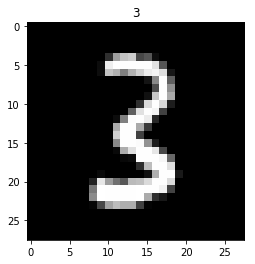

In [17]:
show(x_imgs[0], y_valid[0])

In [18]:
y_valid.shape

(10000,)

In [19]:
y_valid[0]

3

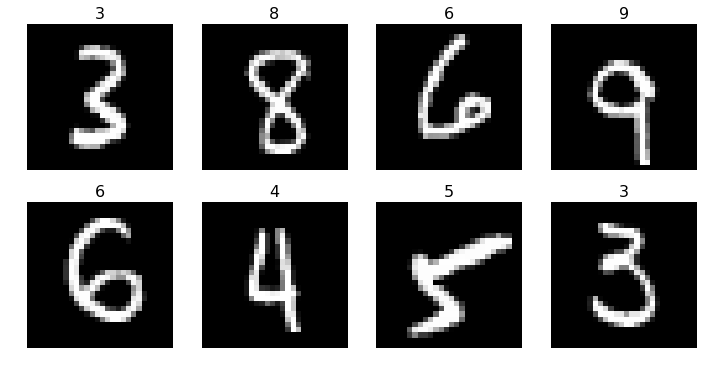

In [20]:
plots(x_imgs[:8], titles=y_valid[:8])

## Neural Networks
**What is a neural network?**  
A *neural network* is an infinitely flexible function, consisting of *layers*. A *layer* is a linear function such as matrix multiplication followed by a non-linear function (the *activation*)

## Logistic regression

## PyTorch

With PyTorch, you can run it on the GPU rather than CPU.

**Launch a GPU computer on AWS:**  
Launch Instances --> Community AMIs --> search fastai --> Select --> Select GPU compute --> p2.xlarge  
(Check DL intro tutorial)


## Neural Net for Logistic Regression in PyTorch

In [21]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
from fastai.core import *

import torch.nn as nn

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class.  
Sequential means I'm going to give you a list of the layers that I want in my neural network. In this case, my list has two things in it. The first things says I want a linear layer, which is something that's going to do y = ax+b. So it is going to do a matrix product basically. So the input of the matrix product is going to be a vector of length 28 times 28 (pixels we have). The output needs to be of size 10.

In [ ]:
net = nn.Sequential(
    nn.Linear(28*28, 10), #because we want 10 predictions [0,10]
    nn.LogSoftmax()
).cuda() 
# cuda tells pytorch to copy this neural network across to the GPU so from now on that network is going to 
# be actually running on the GPU. If we didn't say that it would run on the CPU.

In [23]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

In [24]:
x.shape

(50000, 784)

In [26]:
loss=nn.NLLLoss() #negative log likelihood loss
metrix=[accuracy]
opt=optim.Adam(net.parameters())

NameError: name 'net' is not defined

It is creating a matrix multiplication followed by a non-linearity and that is trying to find the values of this matrix which fit the data as well as possible. Then we optimize the loss function.

In [25]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y) * np.log(1-p)))

In [27]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

What the following code does is it goes through every images `epochs` (i.e. every image once in this case) and go into slightly update the values in that weight matrix based on those gradients. `crit` means the loss function.

In [ ]:
fit(net, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

In [ ]:
preds = predcit(net, md.val_dl)

In [ ]:
preds.shape

In [ ]:
preds.argmax(axis=1)[:5]

In [ ]:
preds = preds.argmax(1)

* [CHAPTER 4 A visual proof that neural nets can compute any function](neuralnetworksanddeeplearning.com/chap4.html)  
* Kaiming He Initialization